# Predict mean radiant temperature with indoor meters
This project aims to use limit conditions to predict the indoor MRT for thermal comfort application.

The building temperature (T<sub>bdg</sub>) will be estimated by finite-difference method with indoor (T<sub>in</sub>) and outdoor (T<sub>out</sub>) temperature and then will be used as globe temperature (T<sub>g</sub>) for MRT prediction.

### The finite-difference method for T<sub>bdg</sub>
T<sub>bdg<sub>t</sub></sub> = T<sub>bdg<sub>t-1</sub></sub>+
(T<sub>o<sub>t</sub></sub>-T<sub>bdg<sub>t-1</sub></sub>)×c<sub>OA</sub>+
(T<sub>in<sub>t</sub></sub>-T<sub>bdg<sub>t-1</sub></sub>)×c<sub>in</sub>×Occ

### Regulate T<sub>bdg</sub> by linear regression to estimate T<sub>g</sub>
T'<sub>bdg</sub> = a×T<sub>bdg</sub>+b = T<sub>g</sub>

### The MRT calculation by assuming T<sub>g</sub>
MRT = [(T<sub>g</sub>+273.15)<sup>4</sup>+2.5×10<sup>8</sup>×v<sub>a</sub><sup>0.6</sup>×(T<sub>g</sub>-T<sub>in</sub>)]<sup>0.25</sup>-273.15


### Import python packages

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

### Import data of office meters and preprocessing
The data include T<sub>in</sub>, T<sub>out</sub>, relative humidity (RH), and occupancy.

In [2]:
path = r'C:\Users\Jacky\Jupyter Projects\Office_Data'
df = pd.read_excel(path+r'\Office_k.xlsx').drop(['index'], axis=1)

The original data are in the resolution of 1 minute which is too compressed to temperature prediction.

In [3]:
# Variables for resample.mean
data_mean = pd.DataFrame(
    # Data
    dict(
        T_in=df['T_z'].values,
        RH=df['Humid'].values,
        T_out=df['T_OA'].values
    ), 
    # Time Index
    df['Time'])
data_mean = data_mean.resample('30min').mean().round(1)
data_mean.reset_index(inplace=True)

# Variables for resample.max
data_max = pd.DataFrame(
    # Data
    dict(Occ=df['Occ'].values), 
    # Time Index
    df['Time'])
data_max = data_max.resample('30min').max()
data_max.reset_index(inplace=True)

# Variables for resample.asfreq
data_freq = pd.DataFrame(
    # Data, transfer the wind level of HRV into wind speed (m/s)
    dict(HRV=df['HRVspeed'].values*0.05), 
    # Time Index
    df['Time'])
data_freq = data_freq.resample('30min').asfreq()
data_freq.reset_index(inplace=True)

# Merge data
data_resample = pd.merge(data_mean, data_max, how="outer", sort=True)
data_resample = pd.merge(data_resample, data_freq, how="outer", sort=True)

# Day of Week
data_resample['DoW'] = [i.weekday()+1 for i in data_resample['Time']]

data_resample

,Time,T_in,RH,T_out,Occ,HRV,DoW
0,2020-07-01 00:00:00,30.2,88.0,28.4,0,0.0,3
1,2020-07-01 00:30:00,30.3,88.7,28.3,0,0.0,3
2,2020-07-01 01:00:00,30.3,88.8,28.1,0,0.0,3
3,2020-07-01 01:30:00,30.3,89.5,28.0,0,0.0,3
4,2020-07-01 02:00:00,30.4,90.4,27.9,0,0.0,3
...,...,...,...,...,...,...,...
4411,2020-09-30 21:30:00,26.7,92.8,22.3,0,0.0,3
4412,2020-09-30 22:00:00,26.7,93.0,22.4,0,0.0,3
4413,2020-09-30 22:30:00,26.6,92.1,22.6,0,0.0,3
4414,2020-09-30 23:00:00,26.5,92.9,22.6,0,0.0,3


### Prepare functions to estimate the building temperature and MRT
We use finite-difference method to estimate the T<sub>g</sub> because there is no globe temperature meter in the office.

In [4]:
## Estimate the building temperature
def T_bdg(coeffs):
    # Set coefficients: 
    # a and b for linear regression;
    # c_OA and c_z for outdoor and indoor factors of finite-difference method
    a, b, c_OA, c_z =coeffs
    
    # Prepare initial values of T_in, T_out, occupancy, and T_bdg
    T_out_arr = data_resample['T_out'].values
    T_in_arr = data_resample['T_in'].values
    occ_arr = data_resample['Occ'].values
    T_bdg_arr = np.zeros([np.size(data_resample,0)])
    
    for i in range(len(T_bdg_arr)):
        # Assume T_bdg balance with T_out in the beginning
        if i==0:
            T_bdg_arr[i] = T_out_arr[i]
        # Then T_bdg will be affected by temperature difference over time
        else:
            T_bdg_arr[i] = T_bdg_arr[i-1] + (T_out_arr[i] - T_bdg_arr[i-1])*c_OA
        
    for i in range(1,len(T_bdg_arr)):
        # T_in and T_out both attribute to T_bdg while the occupancy factor is also considered 
        if ~np.isnan(T_in_arr[i]):
            T_bdg_arr[i] = T_bdg_arr[i-1] + (T_out_arr[i] - T_bdg_arr[i-1])*c_OA + (T_in_arr[i] - T_bdg_arr[i-1])*c_z*occ_arr[i]
    
    # Linear regression will be implemented for regulate T_bdg                        
    return [occ_arr, T_in_arr, a*T_bdg_arr+b]

## The objective will be used to regulate T_bdg
def objective_Err_min(coeffs):
    # Import the estimated data
    occ, Temp_in, Temp_bdg = T_bdg(coeffs)
    
    # Using T_in and T_bdg during unoccupied period as correcting error
    normalized_occ=(occ-occ.mean())/occ.std()
    Err = ((Temp_in-Temp_bdg)*(1-normalized_occ))    
    
    # Assume T_in and T_bdg will balance on weekend and amplify the error effect
    weekday = data_resample['DoW'].values
    Err[weekday>5] = Err[weekday>5]*2.0
    
    # Cleaning data if NaN
    Err[np.isnan(Err)] = 0.0
    return np.sum(Err**2)

## Set initial values and boundaries for coefficients
coeffs_0 = [1.0, 0.0, 0.1, 0.1] 
bnds = ((0.0,1.0),(0.0,2.0),(0.0,0.5),(0.0,0.5))

## Optimize T_bdg with minimum error
solution = minimize(objective_Err_min, coeffs_0, method='SLSQP', bounds=bnds)
coeffs = solution.x

# Print the optimal results
print("Optimal coefficients: [a, b, c_OA, c_Z] = " + str(list(coeffs)))

Optimal coefficients: [a, b, c_OA, c_Z] = [1.0, 0.2, 0.09, 0.14]


Then use the optimal coefficients for T<sub>bdg</sub> and MRT calculation

In [5]:
## Calculate T_bdg
T_bdg_pred = T_bdg(coeffs)[2]
data_resample['T_bdg_pred'] = pd.DataFrame(data=T_bdg_pred)

## Calculate MRT
# Set initial values and assume that indoor MRT balance with T_bdg in the beginning
T_mrt_arr =  [i for i in data_resample['T_bdg_pred']]
for i in range(len(data_resample)):
    if ~np.isnan(data_resample['T_in'][i]):
        T_mrt_arr[i] = ((T_bdg_pred[i] + 273.15) ** 4 + (2.5*10**8)*data_resample['HRV'][i]**0.6*(T_bdg_pred[i] - data_resample['T_in'][i]))**0.25 -273.15
data_resample['MRT'] = pd.DataFrame(data=T_mrt_arr)

# Print the results
data_resample

,Time,T_in,RH,T_out,Occ,HRV,DoW,T_bdg_pred,MRT
0,2020-07-01 00:00:00,30.2,88.0,28.4,0,0.0,3,28.600000,28.600000
1,2020-07-01 00:30:00,30.3,88.7,28.3,0,0.0,3,28.591000,28.591000
2,2020-07-01 01:00:00,30.3,88.8,28.1,0,0.0,3,28.564810,28.564810
3,2020-07-01 01:30:00,30.3,89.5,28.0,0,0.0,3,28.531977,28.531977
4,2020-07-01 02:00:00,30.4,90.4,27.9,0,0.0,3,28.493099,28.493099
...,...,...,...,...,...,...,...,...,...
4411,2020-09-30 21:30:00,26.7,92.8,22.3,0,0.0,3,25.204595,25.204595
4412,2020-09-30 22:00:00,26.7,93.0,22.4,0,0.0,3,24.970182,24.970182
4413,2020-09-30 22:30:00,26.6,92.1,22.6,0,0.0,3,24.774865,24.774865
4414,2020-09-30 23:00:00,26.5,92.9,22.6,0,0.0,3,24.597127,24.597127


### Plot results chart

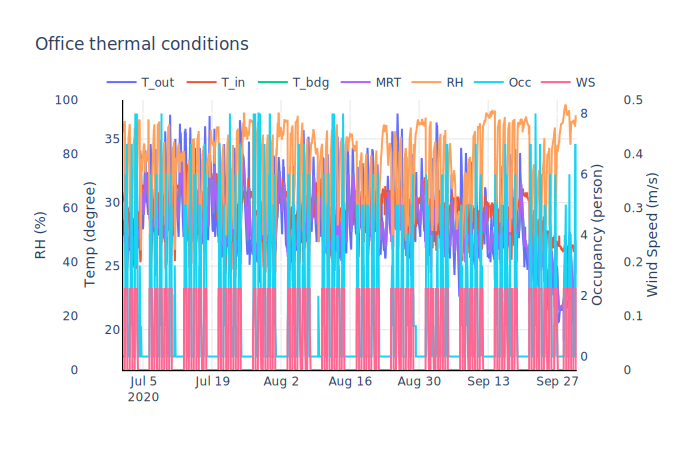

In [6]:
## Plot by plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="T_out",
    x=data_resample['Time'],
    y=data_resample['T_out'],
    mode="lines"))

fig.add_trace(go.Scatter(
    name="T_in",
    x=data_resample['Time'],
    y=data_resample['T_in'],
    mode="lines"))

fig.add_trace(go.Scatter(
    name="T_bdg",
    x=data_resample['Time'],
    y=data_resample['T_bdg_pred'],
    mode="lines"))

fig.add_trace(go.Scatter(
    name="MRT",
    x=data_resample['Time'],
    y=data_resample['MRT'],
    mode="lines"))

fig.add_trace(go.Scatter(
    name="RH",
    x=data_resample['Time'],
    y=data_resample['RH'],
    mode="lines",
    yaxis = "y2"))

fig.add_trace(go.Scatter(
    name="Occ",
    x=data_resample['Time'],
    y=data_resample['Occ'],
    mode="lines",
    yaxis = "y3"))

fig.add_trace(go.Scatter(
    name="WS",
    x=data_resample['Time'],
    y=data_resample['HRV'],
    mode="lines",
    yaxis = "y4"))

fig.update_xaxes(
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)")

fig.update_yaxes(
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)")    

fig.update_layout(
    title=dict(text="Office thermal conditions"),
    xaxis=dict(domain=[0.08, 0.92]),
    yaxis=dict(title=dict(text="Temp (degree)", standoff=0)),
    yaxis2=dict(
        title=dict(text="RH (%)", standoff=0),
        range=[0,100],
        anchor="free",
        overlaying="y",
        side="left",
        position=0),
    yaxis3=dict(
        title=dict(text="Occupancy (person)", standoff=0),
        anchor="free",
        overlaying="y",
        side="right",
        position=0.92),
    yaxis4=dict(
        title=dict(text="Wind Speed (m/s)", standoff=0),
        range=[0, 0.5],
        anchor="free",
        overlaying="y",
        side="right",
        position=1),
    legend=dict(
        orientation="h",
        x=0.04,
        y=1.12),
    plot_bgcolor="white")

The estimated T<sub>bdg</sub> and predicted MRT could then be used for a thermal comfort application.

#### Acknowledgment: The idea is jointly owned with Dr. Patrick Fu at the National University of Singapore.